## Nilearn statistical maps. Plotly interactive brain slice selection and plotting ##

Recently a new `nilearn` [https://github.com/nilearn/nilearn](https://github.com/nilearn/nilearn) version was released. 
The interactive visualization of statistical map slices, as a new feature introduced in this version, suggested a few Plotly experiments intended to visualize more info on  slices during cut point  selection, brain slice plotting or 3d animation.

`nilearn` works with NIfTI images, a common format in  neuroimaging (brain imaging). The NIfTI  images can have  at least 3 dimesions.
The first 3 dimensions are spatial, the fourh one, if exists, is a temporal one, and other dimensions are user defined.

A 3d image array has as basic elements the voxels. A  voxel index, (i, j, k), points out its position in the image.
But the  voxel coordinate system  does not give any information on the  physical dimensions (units) or
on how  the head (brain) relates to the voxel indices. That's why  the volumetric description of the imaging data as a 3d array is complemented with a $4\times 4$ affine transformation, that maps a voxel index, (i, j, k; 1), to MNI (Montreal Neurological Institute) spatial coordinates, $(x,y,z;1)$.

The MNI coordinate system is a right coordinate system (i.e the cross product of the unit vectors of Ox, Oy axes is the unit vector for the Oz axis), that has the origin at an anatomical point called, *anterior commissure* [http://imaging.mrc-cbu.cam.ac.uk/imaging/FindingCommissures](http://imaging.mrc-cbu.cam.ac.uk/imaging/FindingCommissures) and the ] axes are oriented like in the image below: 

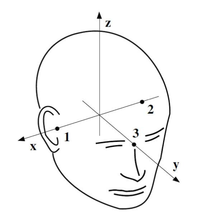

In [3]:
from IPython.display import Image
Image(filename='Data/coordinatesystem_neuromag.png')
#downloaded from url='http://www.fieldtriptoolbox.org/_media/faq/coordinatesystem_neuromag.png?w=200&tok=e89b5d')

MNI units are milimeters. The 3d image data are transformed by the associated affine transformation such that
 to match an averaged brain template, called MNI152 (is it s an average brain taken from MRI's of 152 healthy individuals). 


The code below is  the first attempt to use Plotly for selection and  brain slice  plotting:

In [ ]:
import plotly.graph_objs as go
import plotly.tools as tls

In [ ]:
import numpy as np
import copy
from matplotlib import cm as mpl_cm
import matplotlib as mpl
from nilearn import (plotting, _utils)

In [ ]:
def mpl_to_plotly(cmap, pl_entries):
    # convert a mpl colormap to a Plotly colorscale with pl_entries (colors)
    h=1.0/(pl_entries-1)
    pl_colorscale=[]
    for k in range(pl_entries):
        C=list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([round(k*h,2), f'rgb({C[0]}, {C[1]}, {C[2]})'])
    return pl_colorscale

In [ ]:
def colorscale(cmap, values, threshold=None, symmetric_cmap=True,
               vmax=None, vmin=None):
    """This function modifies nilearn.plotting.js_plotting_utils.colorscale:
    https://github.com/nilearn/nilearn/blob/master/nilearn/plotting/js_plotting_utils.py#L192
    It defines a Plotly colorscale or a mixed Plotly colorscale from a given nilearn or matplotlib colormap,
    and extracts the color range """
    
    cmap = mpl_cm.get_cmap(cmap)
    abs_values = np.abs(values)
    
    if not symmetric_cmap and (values.min() < 0):
        warnings.warn('you have specified symmetric_cmap=False '
                      'but the map contains negative values; '
                      'setting symmetric_cmap to True')
        symmetric_cmap = True
    if symmetric_cmap and vmin is not None:
        warnings.warn('vmin cannot be chosen when cmap is symmetric')
        vmin = None
    if threshold is not None:
        if vmin is not None:
            warnings.warn('choosing both vmin and a threshold is not allowed; '
                          'setting vmin to 0')
        vmin = 0
    if vmax is None:
        vmax = abs_values.max()
    if symmetric_cmap:
        vmin = - vmax
    if vmin is None:
        vmin = values.min()
    
    #Define a mixed colorscale consisting from 3 parts, with gray at center, and  and two diverging cmaps outside
    L=11
    abs_threshold = None
    if threshold is not None:
        abs_threshold = _utils.param_validation.check_threshold(threshold, values, _utils.extmath.fast_abs_percentile)
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        ca = norm(-abs_threshold)
        cb = norm(abs_threshold)
        h1 = ca/L
        dl = [k*h1 for k in range(L)]
        h2 = (cb-ca) / (L-1)
        dc = [ca+k*h2 for k in range(L)]
        h3 = (1-cb-h2) / (L-1)
        dr = [cb+h2+k*h3 for k in range(L)]
        d = dl+dc+dr
        cmaplist = [cmap(t)[:3] for t in d]
        for k in range(L):  
            cmaplist[k+L] = mpl_cm.gray(k*0.1)[:3]
            
        pl_colorscale = []
   
        for k, t in enumerate(d):
            c = list(map(np.uint8, np.array(cmaplist[k])*255))
            pl_colorscale.append([round(t,3), f'rgb({c[0]}, {c[1]}, {c[2]})'])  
    else:
        pl_colorscale = mpl_to_plotly(cmap, L)
    return  {
        'colorscale': pl_colorscale, 'vmin': vmin, 'vmax': vmax, 
        'abs_threshold': abs_threshold}

In [ ]:
def pl_view_img(stat_map_img,  bg_img='MNI152', 
             threshold=1e-6,
             cmap=plotting.cm.cold_hot,
             symmetric_cmap=True,
             dim='auto',
             vmax=None,
             vmin=None,
             resampling_interpolation='continuous',
             **kwargs):
    """
    Reads and processes the background image (MNI152) and a stats image, to be able to
    perform an interactive Plotly view of the coresponding statistical map;
    THIS IS a MODIFIED version of the nilearn view_img function:
    https://github.com/nilearn/nilearn/blob/master/nilearn/plotting/html_stat_map.py#L332
    
    Returns
    -------
    color_info, background, statistical and mask NIfTI images,
    the affine transformation associated to the processed stat image,
    
        
    """    
   
    mask_img, stat_map_img, data, threshold = plotting.html_stat_map._mask_stat_map(stat_map_img, threshold)
    color_info = colorscale(cmap, data.ravel(), threshold=threshold, 
                        symmetric_cmap=symmetric_cmap, vmax=vmax,
                        vmin=vmin)
  
    bg_img, bg_min, bg_max, black_bg = plotting.html_stat_map._load_bg_img(stat_map_img, bg_img, dim)
    
    stat_map_img, mask_img = plotting.html_stat_map._resample_stat_map(stat_map_img, bg_img, mask_img,
                                                resampling_interpolation)
   
    affine_transf = stat_map_img.affine
   
    return [color_info,  
            _utils.niimg._safe_get_data(bg_img, ensure_finite=True), 
            stat_map_img, 
            _utils.niimg._safe_get_data(mask_img, ensure_finite=True), 
            affine_transf]


In [ ]:
def get_plotly_heatmaps(bg_img, stat_map_img,  mask_img,  affine_transf, color_info,
                        cut_coords= None, threshold=3):
             
    # Extract data from the three  NIfTI images  needed to define the  Plotly heatmap traces
    # representing the brain slices
    
    # bg_img:  a numpy array storing the background image data
    # stat_map_img:  a NIfTI image, NOT its data  yet
    # mask_img: numpy array; mask image data
    # affine_transf: numpy array of shape (4,4) as  the affine transformation of the stat_map_img
    # cut_coords: 3-list giving the MNI coordinates where the brain cut is performed
    # color_info: dict for plotly colorscale, and vmin, vmax values to be colormapped
    
    # Returns 
    # the Plotly heatmap traces 
    # and the min-max values of MNI coordinates in each direction
    
    cut_slices =  plotting.html_stat_map._get_cut_slices(stat_map_img, cut_coords, threshold)
    
    stat_map_img = _utils.niimg._safe_get_data(stat_map_img, ensure_finite=True)  
    
    
    #min-max MNI-coordinates  corresponding to min-max voxel indices i, j, k
    xMNI_min, yMNI_min, zMNI_min = affine_transf[:, 3][:3]
    imax, jmax, kmax = stat_map_img.shape 
    xMNI_max, yMNI_max, zMNI_max, one = np.dot(affine_transf, [imax-1, jmax-1, kmax-1, 1])
    
    pl_colorscale=color_info['colorscale']
    vmin=color_info['vmin']
    vmax=color_info['vmax']
    abs_threshold=color_info['abs_threshold']
    
    islice, jslice, kslice = np.array(cut_slices-1, int)# voxel indices corresponding to cut_slices
    
    # Mix the backgraound  and statistical image values according to mask image:
    a, b = -abs_threshold, abs_threshold
    vmin_bg, vmax_bg = bg_img.min(), bg_img.max()
    final_img = copy.deepcopy(stat_map_img) #define the image that will be plotted
    alpha = (b-a) / (vmax_bg-vmin_bg)  
    new_bg = a + alpha * (bg_img-vmin_bg) # map bg_img vals to [a,b]
    I, J, K = np.where(mask_img==1)
    final_img[I, J, K] = new_bg[I, J, K]
    
    # Define  2d arrays storing the image values in the three slices:
    xsts = final_img[islice, :, :]
    ysts = final_img[:, jslice, :]
    zsts = final_img[:, :, kslice]
    
    # Trace definition:  The second char in the  x, y, z names
    # represents the slice name
    #x-slice:
    xx = np.linspace(yMNI_min, yMNI_max, jmax)
    yx = np.linspace(zMNI_min, zMNI_max, kmax)
    textx = [[f'y: {xx[j]}<br>z: {yx[i]}<br>val: '+'{:.2f}'.format(xsts.T[i,j]) for j in range(jmax)] 
              for i in range(kmax)]

    slicex = dict(type='heatmap',
               zsmooth='best',
               x=xx,
               y=yx,
               z=xsts.T,
               text=textx, 
               colorscale=pl_colorscale,     
               colorbar=dict(thickness=20, ticklen=4, tick0=-7, dtick=2),
               showscale=False, 
               hoverinfo='text', 
               zmin=vmin,
               zmax=vmax)
   # y-slice
    xy = np.linspace(xMNI_min, xMNI_max, imax)
    yy = np.linspace(zMNI_min, zMNI_max, kmax)
    texty = [[f'x: {xy[j]}<br>z: {yy[i]}<br>val: '+'{:.2f}'.format(ysts.T[i,j]) for j in range(imax)]
                          for i in range(kmax)]

    slicey = dict(type='heatmap',
               x=xy,
               y=yy,  
               z=ysts.T,
               text=texty, 
               zsmooth='best', 
               colorscale=pl_colorscale,    
               colorbar=dict(thickness=20, ticklen=4, tick0=-7, dtick=2),
               showscale=False, 
               hoverinfo='text', 
               zmin=vmin,
               zmax=vmax)
    # z-slice
    xz = np.linspace(xMNI_min, xMNI_max, imax)
    yz = np.linspace(yMNI_min, yMNI_max, jmax)
    textz = [[f'x: {xz[j]}<br>y: {yz[i]}<br>val: '+'{:.2f}'.format(zsts.T[i,j]) for j in range(imax)]
          for i in range(jmax)]

    slicez = dict(type='heatmap',
               zsmooth='best',
               x=xz,
               y=yz, 
               z=zsts.T,
               text=textz, 
               colorscale=pl_colorscale, 
               colorbar=dict(thickness=20, ticklen=4, tick0=np.ceil(vmin), dtick=2),
               hoverinfo='text',
               zmin=vmin,
               zmax=vmax)
    return [slicex, slicey, slicez, xMNI_min, yMNI_min, zMNI_min, xMNI_max, yMNI_max, zMNI_max]                   

### Interactive view of brain slices through a point given in MNI-coordinates

We define a subplot of three heatmaps representing the orthogonal brain slices through a given point in MNI-coordinates. 
A mouse click on a slice (subplot cell) retrieves the MNI coordinates that  define a new  cut point in the brain: 
    a coordinate is the coordinate of the clicked slice (let us say y in the case of 
the y-slice), and the coordinates of the clicked point (x and z in our example), that complement the first one.

A callback function executed  `on_click`  retrieves a new cut point  and generates the new slices through that point.   

In [ ]:
stat_img = 'Data/image_10426.nii.gz'# from nilearn datasets

color_info,  bg_img, stat_map_img, mask_img, affine_transf = pl_view_img(stat_img, threshold=3)

cut_coords = [13, -27, 50]# Important!!! define cut_coords as a list (not as a tuple!!) because it is
                          # updated during the interactivity
    
slicex, slicey, slicez, xMNI_min, yMNI_min, zMNI_min, xMNI_max, yMNI_max, zMNI_max = \
                  get_plotly_heatmaps(bg_img, stat_map_img,  mask_img,  affine_transf, color_info,
                        cut_coords= cut_coords, threshold=3)
   

The affine transformation, associated to the processed `stat_map_img` is listed below:

In [ ]:
affine_transf

It consists in a scaling of factor 2, and a translation that places the voxel of index (0,0,0) to the  point of MNI coordinates
$(x=-90, y=-126, z=-72)$.


Define the Plotly subplots:

In [ ]:
fig= tls.make_subplots(subplot_titles=(f'Slice x={cut_coords[0]}', f'Slice y={cut_coords[1]}',
                                       f'Slice z={cut_coords[2]}'),                   
                       rows=1,
                       cols=3,
                       horizontal_spacing=0.065,
                      )

In [ ]:
fw = go.FigureWidget(fig) # convert fig to a FigureWidget 

In [ ]:
fw.add_trace(slicex, 1, 1)
fw.add_trace(slicey, 1, 2)
fw.add_trace(slicez, 1, 3)#HOW TO STOP THIS automaticaly json display?

In [ ]:
with fw.batch_update():
    fw.layout.update(title='Orthogonal brain slices through a point',
                    width=1000, height=425)
    fw.layout.xaxis1.update(range=[yMNI_min, yMNI_max], title='y')
    fw.layout.yaxis1.update(range=[zMNI_min, zMNI_max], title='z')
    fw.layout.xaxis2.update(range=[xMNI_min, xMNI_max], title='x')
    fw.layout.yaxis2.update(range=[zMNI_min, zMNI_max], title='z')
    fw.layout.xaxis3.update(range=[xMNI_min, xMNI_max], title='x')
    fw.layout.yaxis3.update(range=[yMNI_min, yMNI_max], title='y')
   

Now let us define a callback function to be executed when a point in one of the three slices is clicked.

In [ ]:
slice_name=['x', 'y', 'z']

def clicked_trace(trace, points, state):
    global cut_coords, slice_name
    if points.trace_index in [0, 1, 2]:
        idx = points.trace_index
        if len(points.xs) != 0:
            xclicked, yclicked = points.xs[0], points.ys[0]
            if idx == 0:
                cut_coords[1:] = [xclicked, yclicked]
            elif idx == 1:
                cut_coords[0], cut_coords[2] = xclicked, yclicked 
            else: # idx == 2:
                cut_coords[:2] = [xclicked, yclicked ] 
            tr = get_plotly_heatmaps(bg_img, stat_map_img,  mask_img,  affine_transf, color_info,
                        cut_coords= cut_coords)
            with fw.batch_update():
                fw.update(data=[tr[0], tr[1], tr[2]])
                for k in range(3):
                    fw.layout.annotations[k].text=f'Slice {slice_name[k]}={cut_coords[k]}'

for trace in fw.data:                    
    trace.on_click(clicked_trace)
fw     

Let display the  `nilearn` version of the above slices:

In [ ]:
%matplotlib inline

view = plotting.view_img(stat_img, cut_coords=cut_coords, threshold=3)
view

The Plotly plot displays the range of axes, and provides the possibility to select a particular point 
in a slice, by hovering an area of interest, and choosing the  point of desired coordinates,
while in the original nilearn plot  a blind point selection is performed, whose coordinates are seen a posteriori.

To realize how Plotly cut point selection works, before running this notebook,  see the gif file:

In [4]:
%%html
<img src='2d-brain-slices.gif'>